# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set root path
root_path = os.path.abspath('../')
print("Bachelorarbeit-root:", root_path)

train_data_path = f'{root_path}/masks_dataset/train/augmented'
validation_data_path = f'{root_path}/masks_dataset/validation'

model_save_path = root_path

Bachelorarbeit-root: /Users/carinastiedl/Documents/Hochschule/mask-classification-model


In [3]:
# Define parameters
batch_size = 32
image_size=(180,180)

In [4]:
# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 8994 files belonging to 2 classes.
Using 7196 files for training.


2022-08-11 15:40:15.650737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 306 files belonging to 2 classes.
Using 61 files for validation.


In [6]:
class_names = train_ds.class_names
%store class_names
print(class_names)

Stored 'class_names' (list)
['mask', 'no_mask']


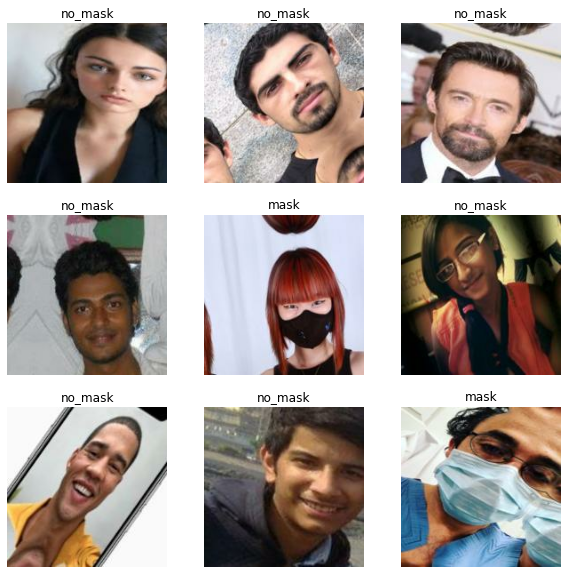

In [7]:
# visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #keep images in memory -> faster training
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #overlap data preprocessing and model execution while training

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size[0],image_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1, seed=None)
  ]
)

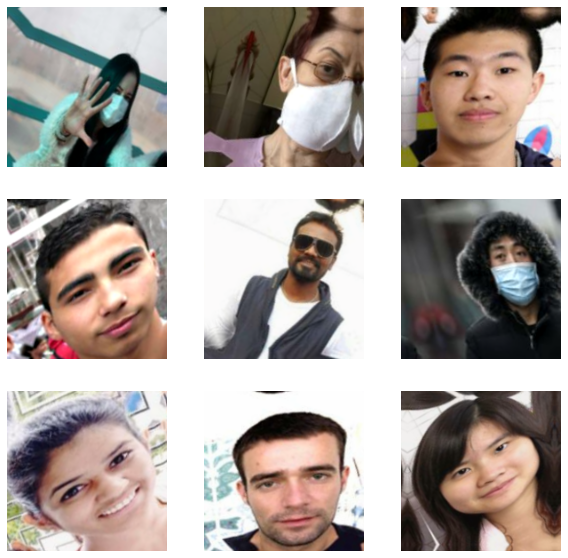

In [10]:
# Show example of augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
# create model
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(image_size[0],image_size[1], 3)), #smaller values than RBG channel values
    layers.Conv2D(32, (7,7), padding='same', activation='relu'),  #filters, kernel_size
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [12]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

In [14]:
# create checkpoint at best performance epoch
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1, shuffle=True)

In [16]:
# train the model
epochs=20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[mc]
)

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8655
Epoch 1: val_accuracy improved from 0.85246 to 0.90164, saving model to best_model.h5
225/225 [==============================] - 182s 808ms/step - loss: 0.3322 - accuracy: 0.8655 - val_loss: 0.2750 - val_accuracy: 0.9016
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8733
Epoch 2: val_accuracy did not improve from 0.90164
225/225 [==============================] - 185s 820ms/step - loss: 0.3053 - accuracy: 0.8733 - val_loss: 0.2919 - val_accuracy: 0.8525
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8845
Epoch 3: val_accuracy did not improve from 0.90164
225/225 [==============================] - 182s 807ms/step - loss: 0.2874 - accuracy: 0.8845 - val_loss: 0.3384 - val_accuracy: 0.8689
Epoch 4/20
225/225 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8901
Epoch 4: val_accuracy d

In [17]:
# optional: save final model
model.save(model_save_path)

2022-08-11 16:49:44.917480: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/carinastiedl/Documents/Hochschule/Bachelorarbeit/src/jupyter/output/final_model/assets


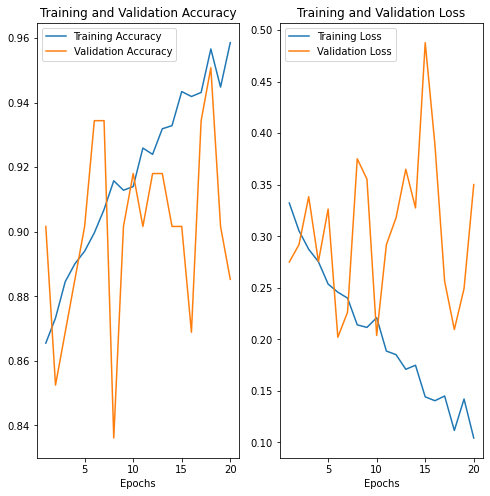

In [25]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1,epochs+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss')
plt.savefig('AccuracyLoss.png')
plt.show()